# Лабораторная работа №2: Фильтрация изображений

*Вариант 2*

Выполнил:

студент группы 6132-010402D

Баканов Дмитрий

*Исходные данные*

| Вероятность p |                           Вид окна ранговой фильтрации                           |                                     Ядро КИХ фильтра                                     |
|:-------------:|:--------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------------:|
|  0,08         | $ \left(\begin{array}{ccc} 2 & 1 & 2\\ 1 & 1 & 1\\ 2 & 1 & 2\end{array}\right)$  | $ \frac 1{11} \left(\begin{array}{ccc}1 & 1 & 1\\1 & 3 & 1\\1 & 1 & 1\end{array}\right)$ |

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
from IPython.display import clear_output

from typing import List, Optional

import warnings

from tqdm import tqdm

warnings.filterwarnings("ignore")

%matplotlib inline


IMAGE_PATH = "./images/Lenna.png"


def plot_image(input_image: np.ndarray) -> None:
    """Функция отрисовки изображения."""
    image_shape = input_image.shape
    plt.axis("off")
    if len(image_shape) == 3:
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(input_image, cmap='gray')


def mean_squared_error(original_image: np.ndarray, filter_image: np.ndarray) -> float:
    """Функция подсчета СКО."""
    return np.square(original_image - filter_image).mean()

*Задание 1. Считать цветное rgb изображение.*

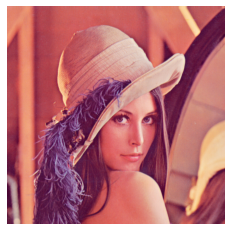

In [2]:
image = cv2.imread(IMAGE_PATH)
plot_image(image)

In [3]:
image.shape

(512, 512, 3)

In [4]:
print("Проверка подсчета СКО:")
print(f"СКО: {mean_squared_error(image, image)}")

Проверка подсчета СКО:
СКО: 0.0


*Задание 2. Зашумить изображение аддитивным шумом с вероятностью p (по вариантам).*
  *   __Вход__: изображение из пункта 1
  *   __Вывод__: зашумленное изображение

In [5]:
def additive_noise(input_image: np.ndarray, probability: float = 0.08) -> np.ndarray:
    """Функция добавления аддитивного шума."""
    rows, cols, channels = input_image.shape
    result_image = input_image.copy()
    pixels_combinations = list(itertools.product(range(image.shape[0]), range(image.shape[1])))
    noise_pixels = [pixel for pixel in pixels_combinations if np.random.random() <= probability]
    for noise_pixel in noise_pixels:
        for channel in range(channels):
            if result_image[noise_pixel[0], noise_pixel[1]][channel] + 50 > 255:
                result_image[noise_pixel[0], noise_pixel[1]][channel] = 255
            else:
                result_image[noise_pixel[0], noise_pixel[1]][channel] += 50

    return result_image

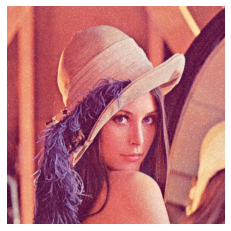

In [6]:
noise_image = additive_noise(image)
plot_image(noise_image)

*Задание 3. Написать функцию реализации ранговой фильтрации.*

> Функцию вида fun(Image, window, rank)
Где window  - окно фильтрации (по вариантам)
rank - опциональный параметр, значение ранга в ранговой фильтрации

In [7]:
def rank_filtering(input_image: np.ndarray, window: np.ndarray, rank: Optional[int] = 2) -> np.ndarray:
    """Ранговая фильтрация."""
    rank -= 1
    image_rows, image_cols, image_channels = input_image.shape
    window_cols, window_rows = window.shape
    filtering_image = np.zeros((image_rows, image_cols, image_channels), dtype=np.uint8)

    for i in tqdm(range(window_rows // 2, image_rows - window_rows // 2)):
        for j in range(window_cols // 2, image_cols - window_cols // 2):
            x_start, x_end = i - window_rows // 2, i + window_rows // 2 + 1
            y_start, y_end = j - window_cols // 2, j + window_cols // 2 + 1

            current_window = input_image[x_start : x_end, y_start : y_end]

            filtering_image[i, j] = get_ranked_value(current_window, window, rank)

    clear_output()
    return filtering_image


def get_ranked_value(image_window: np.ndarray, window: np.ndarray, rank: int) -> np.ndarray:
    """Выдаем ранговое значение."""
    rows, cols, channels = image_window.shape
    result_value = np.zeros((channels,), dtype=np.uint8)

    for channel in range(channels):
        weighted_values = []
        for i in range(rows):
            for j in range(cols):
                for _ in range(window[i, j]):
                    weighted_values.append(image_window[i, j, channel])

        result_value[channel] = list(sorted(weighted_values))[rank]

    return result_value

*Задание 4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам).*
*Подсчитать СКО для результата фильтрации с каждым рангом.*

  *   __Вход__: изображение из пункта 2
  *   __Вывод__: Значения СКО для каждого ранга. Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованные изображения для первого, последнего ранга, а так же для ранга с наименьшим СКО.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

In [8]:
RANK_WINDOW = np.array([[2, 1, 2], [1, 1, 1], [2, 1, 2]])
RANK_WINDOW

array([[2, 1, 2],
       [1, 1, 1],
       [2, 1, 2]])

Зашумленное изображение:
СКО: 14.717693328857422


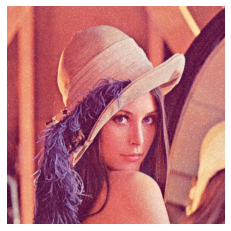

In [9]:
print("Зашумленное изображение:")
plot_image(noise_image)
print(f"СКО: {mean_squared_error(image, noise_image)}")

Изображение, отфильтрованное ранговой обработкой с рангом 2
СКО: 50.79077275594076


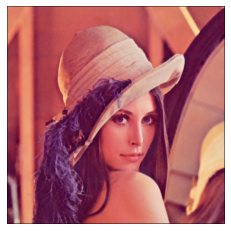

In [10]:
rank_filtering_image = rank_filtering(noise_image, window=RANK_WINDOW, rank=2)
print("Изображение, отфильтрованное ранговой обработкой с рангом 2")
plot_image(rank_filtering_image)
print(f"СКО: {mean_squared_error(image, rank_filtering_image)}")

In [11]:
max_rank = np.sum(RANK_WINDOW.flatten())

filtering_results = []
for r in range(1, max_rank + 1):
    print(f"Ранг {r}")
    fil_image = rank_filtering(noise_image, window=RANK_WINDOW, rank=r)
    mse = mean_squared_error(image, fil_image)
    filtering_results.append((r, mse))
    clear_output()

result_evaluations = sorted(filtering_results, key=lambda x: x[1])
result_evaluations

[(7, 23.359774271647137),
 (6, 24.775870005289715),
 (5, 28.75011698404948),
 (8, 29.852025349934895),
 (4, 33.15914789835612),
 (9, 37.134544372558594),
 (3, 40.62903594970703),
 (10, 46.12981414794922),
 (2, 50.79077275594076),
 (1, 56.81008656819662),
 (11, 59.28803634643555),
 (12, 77.54019165039062),
 (13, 96.29438400268555)]

Зашумленное изображение:
СКО: 14.717693328857422


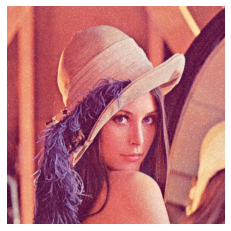

In [12]:
print("Зашумленное изображение:")
plot_image(noise_image)
print(f"СКО: {mean_squared_error(image, noise_image)}")

Лучшая фильтрация (ранг = 7):
СКО: 23.359774271647137


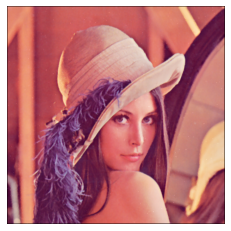

In [13]:
best_rank = result_evaluations[0][0]
best_fil_image = rank_filtering(noise_image, window=RANK_WINDOW, rank=best_rank)
print(f"Лучшая фильтрация (ранг = {best_rank}):")
plot_image(best_fil_image)
print(f"СКО: {mean_squared_error(image, best_fil_image)}")

Худшая фильтрация (ранг = 13):
СКО: 96.29438400268555


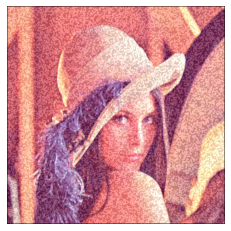

In [14]:
worst_rank = result_evaluations[-1][0]
worst_fil_image = rank_filtering(noise_image, window=RANK_WINDOW, rank=worst_rank)
print(f"Худшая фильтрация (ранг = {worst_rank}):")
plot_image(worst_fil_image)
print(f"СКО: {mean_squared_error(image, worst_fil_image)}")

*Задание 5. Написать функцию реализации свертки*

> Функцию вида fun(mat1, mat2)
Где mat1  - первый сигнал. В данном случае изображение
mat2 - второй сигнал. В данном ядро КИХ фильтра

In [15]:
def convolution(input_image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Функция реализации свертки."""

    rows, cols, channels = input_image.shape
    result = np.zeros_like(input_image)

    kernel_x, kernel_y = kernel.shape

    augmented_image = np.zeros((rows + 2, cols + 2, channels))
    augmented_image[ 1 : -1, 1 : -1, :] = input_image

    for i in tqdm(range(rows)):
        for j in range(cols):
            for channel in range(channels):
                result[i, j, channel] = (kernel * augmented_image[
                                                  i : i + kernel_x,
                                                  j : j + kernel_y,
                                                  channel,
                                                  ]).sum()
                if result[i, j, channel] > 255:
                    result[i, j, channel] = 255

                if result[i, j, channel] < 0:
                    result[i, j, channel] = 0

    clear_output()
    return result

*Задание 6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам.*
*Подсчитать СКО. Сравнить с результатами пункта 4.*

  *   __Вход__: изображение из пункта 2
  *   __Вывод__: Значения СКО . Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение.
  *   СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

In [16]:
FIR_KERNEL = 1 / 11 * np.array([[1, 1, 1], [1, 3, 1], [1, 1, 1]])
print("Ядро КИХ-фильтра")
print(FIR_KERNEL)
print(f"Сумма элементов ядра: {np.sum(FIR_KERNEL.flatten())}")

Ядро КИХ-фильтра
[[0.09090909 0.09090909 0.09090909]
 [0.09090909 0.27272727 0.09090909]
 [0.09090909 0.09090909 0.09090909]]
Сумма элементов ядра: 1.0


Зашумленное изображение:
СКО: 14.717693328857422


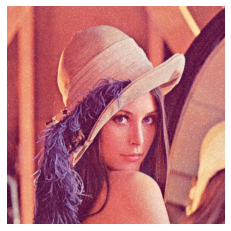

In [17]:
print("Зашумленное изображение:")
plot_image(noise_image)
print(f"СКО: {mean_squared_error(image, noise_image)}")

Получившееся после КИХ-фильтра изображение:
СКО: 37.51056925455729


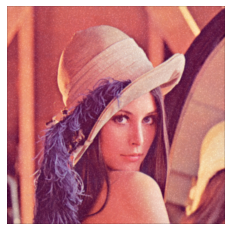

In [18]:
FIR_fil_image = convolution(noise_image, FIR_KERNEL)

print("Получившееся после КИХ-фильтра изображение:")
plot_image(FIR_fil_image)
print(f"СКО: {mean_squared_error(image, FIR_fil_image)}")